<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
# !apt update && apt install -y openslide-tools
# !pip install openslide-python

In [2]:
# !rm -r "/content/drive/MyDrive/Teaching&Thesis/Teaching_dataset/teaching-MLinAPP"
# !git clone https://github.com/frpnz/teaching-MLinAPP.git "/content/drive/MyDrive/Teaching&Thesis/Teaching_dataset/teaching-MLinAPP"

In [3]:
import os
import sys
import openslide
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = 'true'
import matplotlib.pyplot as plt
import openslide.deepzoom as dz
from sklearn import model_selection
rootdir_wsi = "/space/ponzio/CRC_ROIs_5_classes/"
rootdir_src = "/space/ponzio/teaching-MLinAPP/src/"
sys.path.append(rootdir_src)
from resnet import ResNet
from dataset_wsi import DatasetWSI
# ----------------------
tile_size = 500
overlap = 6
input_shape = (512, 512, 3)
epochs = 10
batch_size = 32
class_dict = {
    "AC": 0,
    "H": 1,
    "Serr": 2,
    "T": 3,
    "V": 4}
# ----------------------
num_classes = len(class_dict.keys())
wsi_file_paths = glob(os.path.join(rootdir_wsi, '*.svs'))
df = pd.DataFrame([os.path.basename(slide).split('.')[0].split('_') for slide in wsi_file_paths], columns=["Patient",
                                                                                                           "Type",
                                                                                                           "Sub-type",
                                                                                                           "Dysplasia",
                                                                                                           "#-Annotation"])
df['Path'] = wsi_file_paths
splitter = model_selection.GroupShuffleSplit(test_size=.20, n_splits=2, random_state=7)
split = splitter.split(df, groups=df['Patient'])
train_inds, test_inds = next(split)
wsi_file_paths_train = df['Path'][train_inds]
wsi_file_paths_test = df['Path'][test_inds]
wsi_labels_train = df['Sub-type'][train_inds]
wsi_labels_test = df['Sub-type'][test_inds]

In [4]:
dataset_train = DatasetWSI(wsi_file_paths_train,
                           wsi_labels_train,
                           class_dict,
                           input_shape,
                           batch_size=batch_size,
                           tile_size=tile_size,
                           overlap=6).make_dataset()
dataset_test = DatasetWSI(wsi_file_paths_test,
                          wsi_labels_test,
                          class_dict,
                          input_shape,
                          batch_size=batch_size,
                          tile_size=tile_size,
                          overlap=6).make_dataset()

Stats:
121 slides
2965 images of size 500x500
5 classes
Stats:
39 slides
610 images of size 500x500
5 classes


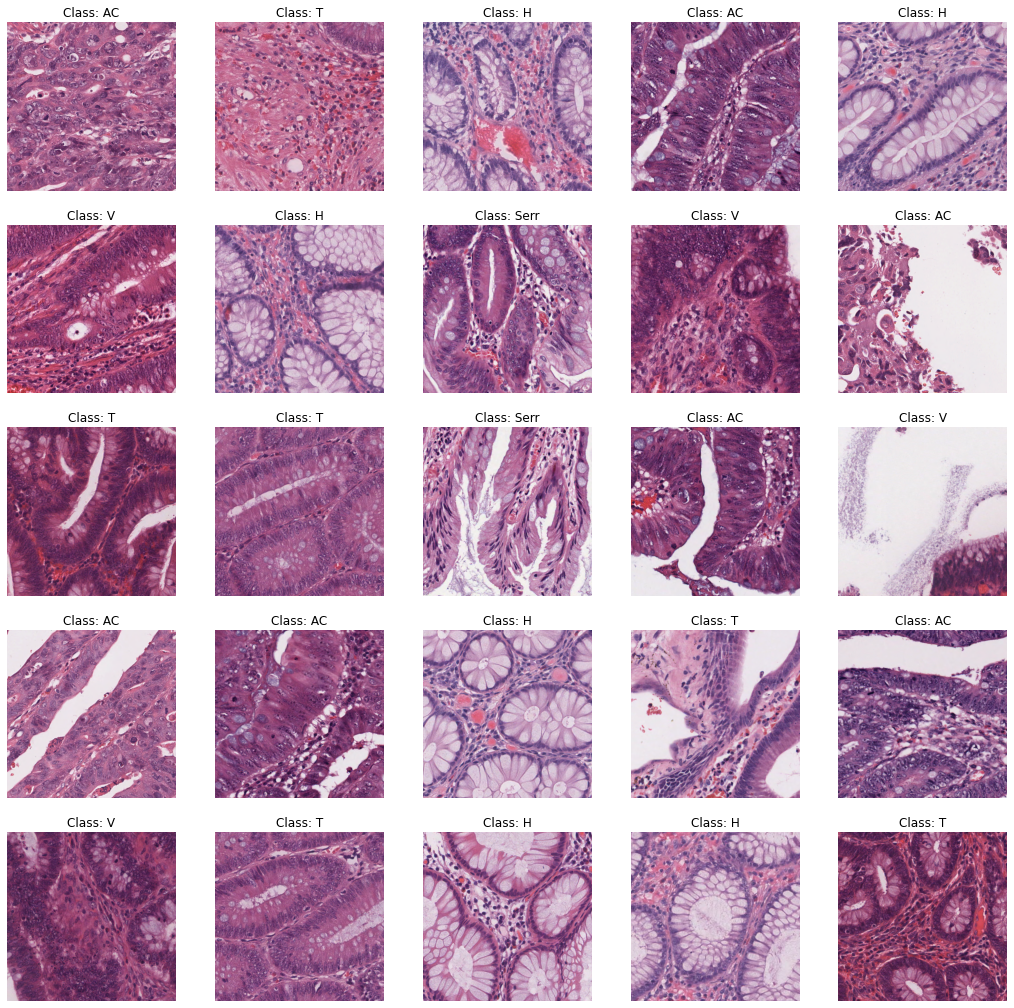

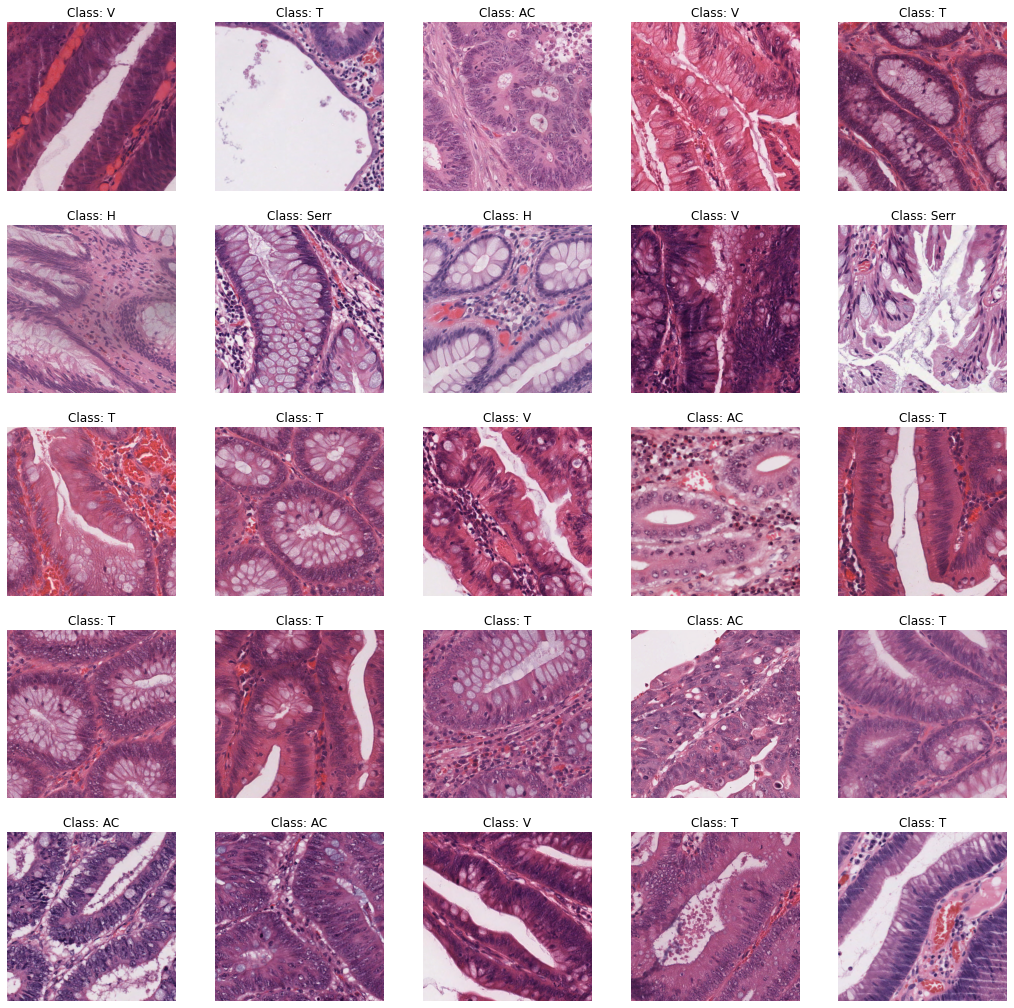

In [6]:
inv_class_dict = {v: k for k, v in class_dict.items()}
for batch_x, batch_y in dataset_train.take(2):
    fig, ax = plt.subplots(5, 5, figsize=(18, 18))
    ax = ax.ravel()
    j = 0
    for image, label in zip(batch_x[:25], batch_y[:25]):
        label = label.numpy()
        img = image.numpy()
        ax[j].imshow(img)
        ax[j].axis('off')
        ax[j].set_title("Class: {}".format(inv_class_dict[int(np.argmax(label))]))
        j += 1

In [11]:
augmentation_block = [
    tf.keras.layers.Resizing(112, 112),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomZoom(
        height_factor=(-0.05, -0.15),
        width_factor=(-0.05, -0.15)),
    tf.keras.layers.RandomRotation(0.3)
]

In [12]:
inputs = tf.keras.Input((512, 512, 3))
x =  tf.keras.applications.resnet50.preprocess_input(inputs)
for layer in augmentation_block:
    x = layer(x)
x = tf.keras.applications.ResNet50(include_top=False, weights="imagenet")(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
model = tf.keras.models.Model(inputs=inputs, outputs=x)
# model = ResNet((input_shape[0], input_shape[1]), 
#                num_classes=num_classes, 
#                augment=True)

In [13]:
checkpoint_filepath = './checkpoint_crc_5_cls'                                                                                                                                                             
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(                                                                                                                                          
    filepath=checkpoint_filepath,                                                                                                                                                                        
    save_weights_only=True,                                                                                                                                                                              
    monitor='accuracy',                                                                                                                                                                              
    mode='max',                                                                                                                                                                                          
    save_best_only=True)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='accuracy',
    factor=0.1,
    patience=7,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)

In [15]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
loss = tf.keras.losses.categorical_crossentropy
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

In [16]:
model.fit(dataset_train, epochs=1, callbacks=[checkpoint_callback, lr_callback])

51/51 [==============================] - 186s 3s/step - loss: 1.4320 - accuracy: 0.4097


In [19]:
results = model.evaluate(dataset_test)

9/9 [==============================] - 37s 4s/step - loss: 2.1437 - accuracy: 0.1068
Accuracy: 2.143704652786255


In [20]:
print("Accuracy: {}".format(results[1]))

Accuracy: 0.10676156729459763
